In [1]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from flax import struct
from flax.training.train_state import TrainState
from flax.core import FrozenDict
from typing import Any, Dict, Tuple

import jax, jax.numpy as jnp
from jax.random import PRNGKey
from flax import linen as nn
from typing import Tuple


from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [2]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [3]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [4]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # cut off gradients after Gibbs sampling

        loss = jnp.mean(self._free_energy(data)) - jnp.mean(self._free_energy(gibbs_chain))
        return loss, {"gibbs_chain": gibbs_chain, "key": key}

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [5]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        gibbs_chain: jnp.ndarray,
        key: PRNGKey) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")

    (basis_key, batch), = batch_dict.items()
    if set(basis_key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {basis_key}")

    aux_vars = {"gibbs_chain": gibbs_chain, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"]

def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for batch_dict in loader:
            state, loss, gibbs_chain, key = train_step_amp(state, batch_dict, gibbs_chain, key)
            tot_loss += loss
            batches += 1

        metrics[epoch] = {"loss_amp": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_amp']:.4f}")

    return state, metrics

In [136]:
# ---- hyperparameters ----
batch_size    = 64
visible_units = 10
hidden_units  = visible_units * 2
k_steps       = 100
lr            = 1e-2
num_epochs    = 200
chains        = batch_size

key_seed = PRNGKey(42)
key, key_params, key_chains, key_dummy = jax.random.split(key_seed, 4)

model_amp = RBM(visible_units, hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, visible_units), dtype=jnp.float32), "key": key_dummy}
variables_amp = model_amp.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=batch_size)

optimizer_amp = optax.adam(learning_rate=lr)
state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)
gibbs_chain = jax.random.bernoulli(key_chains, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

In [137]:
%time state_amp, metrics_amp = train_amp_rbm(state_amp, loader_amp, gibbs_chain, num_epochs, key)

Epoch 1/200 │ Loss: -1.2182
Epoch 2/200 │ Loss: -1.5968
Epoch 3/200 │ Loss: -0.9756
Epoch 4/200 │ Loss: -0.5155
Epoch 5/200 │ Loss: -0.2351
Epoch 6/200 │ Loss: -0.1512
Epoch 7/200 │ Loss: -0.0927
Epoch 8/200 │ Loss: -0.0667
Epoch 9/200 │ Loss: -0.0696
Epoch 10/200 │ Loss: -0.0562
Epoch 11/200 │ Loss: -0.0830
Epoch 12/200 │ Loss: -0.0474
Epoch 13/200 │ Loss: -0.0634
Epoch 14/200 │ Loss: -0.0646
Epoch 15/200 │ Loss: -0.0561
Epoch 16/200 │ Loss: -0.0723
Epoch 17/200 │ Loss: -0.0350
Epoch 18/200 │ Loss: -0.0513
Epoch 19/200 │ Loss: -0.0685
Epoch 20/200 │ Loss: -0.0487
Epoch 21/200 │ Loss: -0.0650
Epoch 22/200 │ Loss: -0.0481
Epoch 23/200 │ Loss: -0.0452
Epoch 24/200 │ Loss: -0.0199
Epoch 25/200 │ Loss: -0.0509
Epoch 26/200 │ Loss: -0.0472
Epoch 27/200 │ Loss: -0.0481
Epoch 28/200 │ Loss: -0.0424
Epoch 29/200 │ Loss: -0.0165
Epoch 30/200 │ Loss: -0.0329
Epoch 31/200 │ Loss: -0.0665
Epoch 32/200 │ Loss: -0.0338
Epoch 33/200 │ Loss: -0.0298
Epoch 34/200 │ Loss: -0.0152
Epoch 35/200 │ Loss: -0

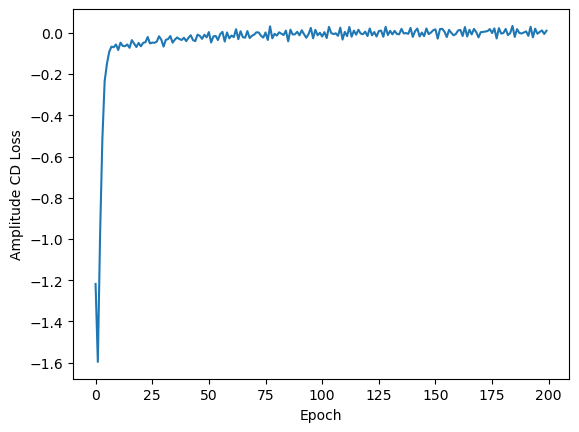

In [138]:
plt.plot([metrics_amp[epoch]['loss_amp'] for epoch in metrics_amp])
plt.xlabel("Epoch")
plt.ylabel("Amplitude CD Loss")
plt.show()

In [139]:
key_sample = PRNGKey(1234)

samples = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    key=key_sample,
    method=RBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.13939999, 0.13149999, 0.13939999, 0.13419999, 0.1522    ,
       0.1415    , 0.1419    , 0.139     , 0.1471    , 0.1302    ],      dtype=float32)

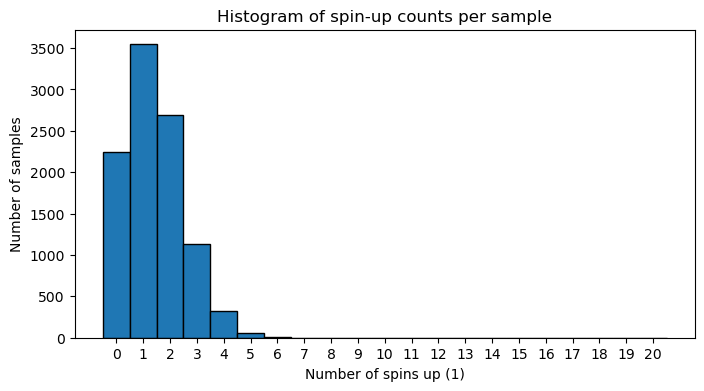

In [140]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [141]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in loader_amp:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.0959375 , 0.09953125, 0.09640625, 0.0984375 , 0.09984375,
       0.10265625, 0.09671875, 0.101875  , 0.109375  , 0.09921875],      dtype=float32)

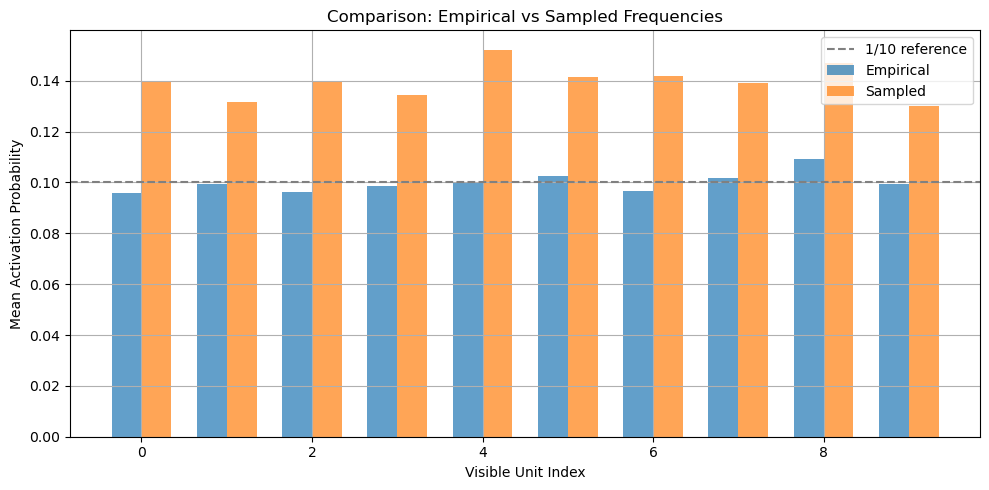

In [142]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()